# Research Question 1: River extent of influence

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

If proportion of Mn concentration at the particular point in space that is due to the contribution from rivers is greater than x, then the point is defined as in the river domain. Check on 5-day output time scale and on monthly average timescales.

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt

%matplotlib notebook

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load domain dimensions for reference:

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask = tmask[0,:,1480:2050,160:800]

In [5]:
ref   = nc.Dataset('/data/brogalla/ANHA12/2015/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
lons  = np.array(ref.variables['nav_lon'])[1480:2050,160:800]
lats  = np.array(ref.variables['nav_lat'])[1480:2050,160:800]
depth = np.array(ref.variables['deptht'])

##### Load Mn model run results:

In [8]:
folder = '/data/brogalla/run_storage/'
file   = 'ANHA12_EXH006_2002_monthly.nc'
 
base   = 'riv-base_2019-06-28T154859.121945-0400/'
glac   = 'riv-glacier_2019-06-25T170724.890280-0400/'

In [9]:
base_monthly = nc.Dataset(folder+base+file)
glac_monthly = nc.Dataset(folder+glac+file)

In [13]:
dmn_base_monthly = np.array(base_monthly.variables['dissolmn'])[:,0,:,:,:]
dmn_glac_monthly = np.array(glac_monthly.variables['dissolmn'])[:,0,:,:,:]

In [22]:
tmask_full    = np.empty(dmn_glac_monthly.shape)
tmask_full[:] = tmask

In [23]:
cglacier_monthly   = dmn_glac_monthly - dmn_base_monthly[0:-1,:,:,:]
mcglacier_monthly  = np.ma.masked_where((tmask_full < 0.1), cglacier_monthly)

mbase_monthly      = np.ma.masked_where((tmask_full < 0.1), dmn_base_monthly[0:-1,:,:,:])
mglac_monthly      = np.ma.masked_where((tmask_full < 0.1), dmn_glac_monthly)

Calculate the proportional contribution of glacial rivers to each grid cell:

In [24]:
def calculate_river_prop(dmn_riv_on, dmn_riv_off):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers at each point
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [25]:
glacier_prop   = calculate_river_prop(mglac_monthly, mbase_monthly)

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


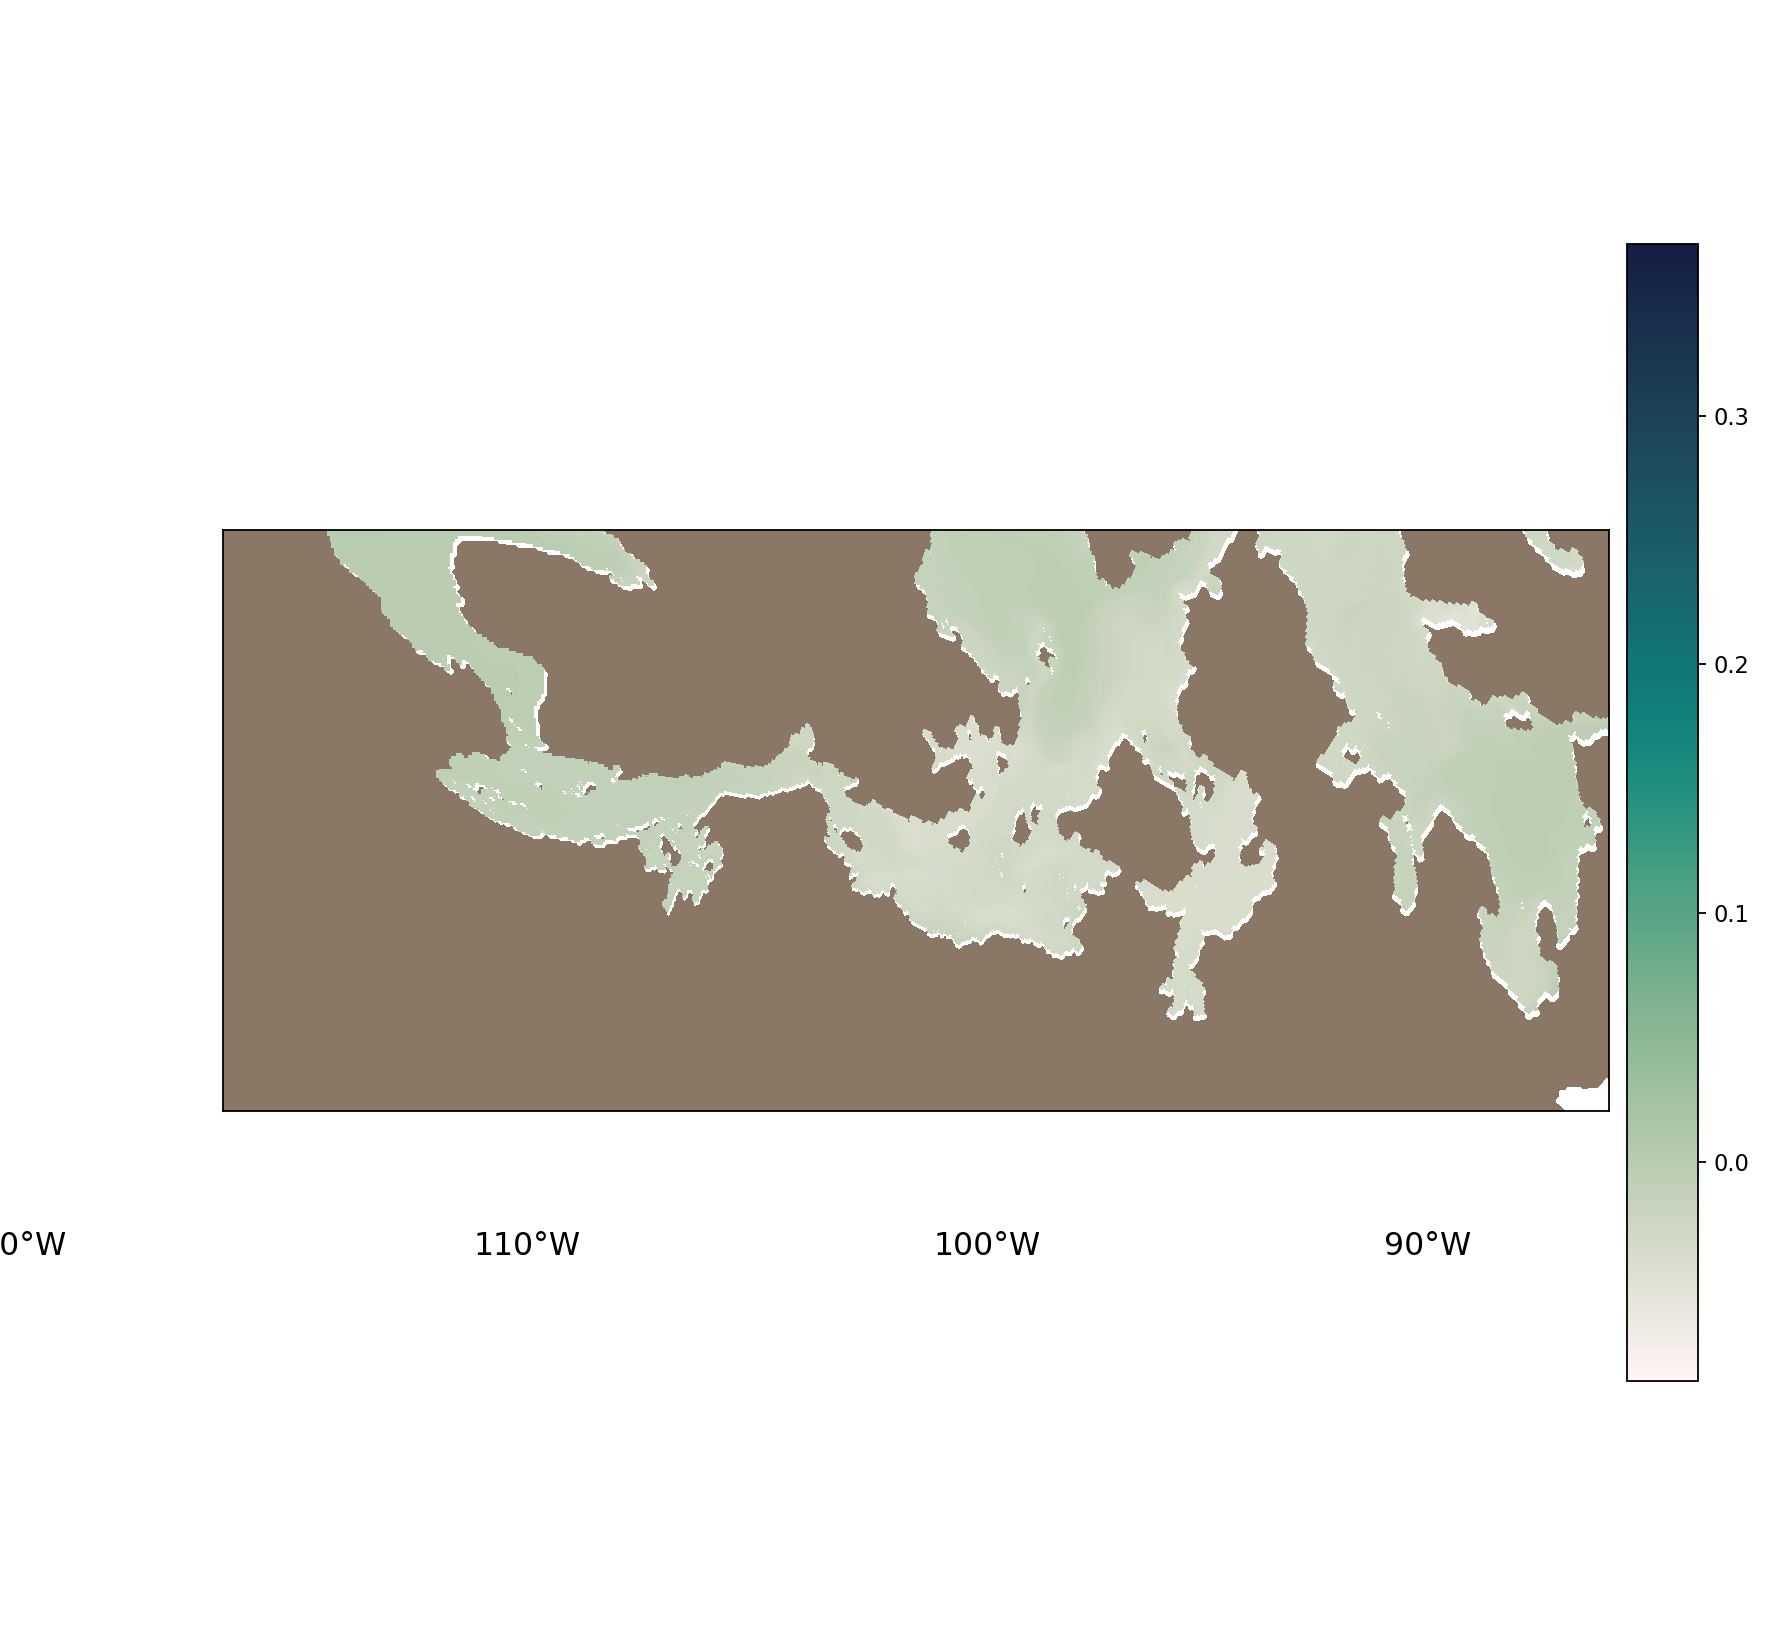

In [26]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y    = proj(lons, lats)
colour  = cmocean.cm.tempo

cbar    = proj.pcolor(x, y, glacier_prop[8,0,:,:], cmap=colour)
    
fig     = plt.gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

In [14]:
def find_RCD(prop_river, tmask, RCD_def=0.3):
    # Input arguments:
    # - prop_river (t,z,y,x) --- contribution of riverine input to total Mn concentration at this point in space
    # - tmask (z,y,x)        --- land mask
    # - RCD_def              --- definition of proportion above which a point is strongly influenced by rivers
    
    # Apply land mask to prop_river grid:
    mprop_river = np.ma.masked_where((tmask < 0.1), prop_river)
    
    RCD = (mprop_river >= RCD_def).astype(int)
    
    # Output:
    # - RCD (t,z,y,x) --- returns 0 (not RCD) or 1 (RCD) for each grid point
    return RCD

In [15]:
RCD_glac = find_RCD(glacier_prop, tmask_full, RCD_def=0.05)

<IPython.core.display.Javascript object>


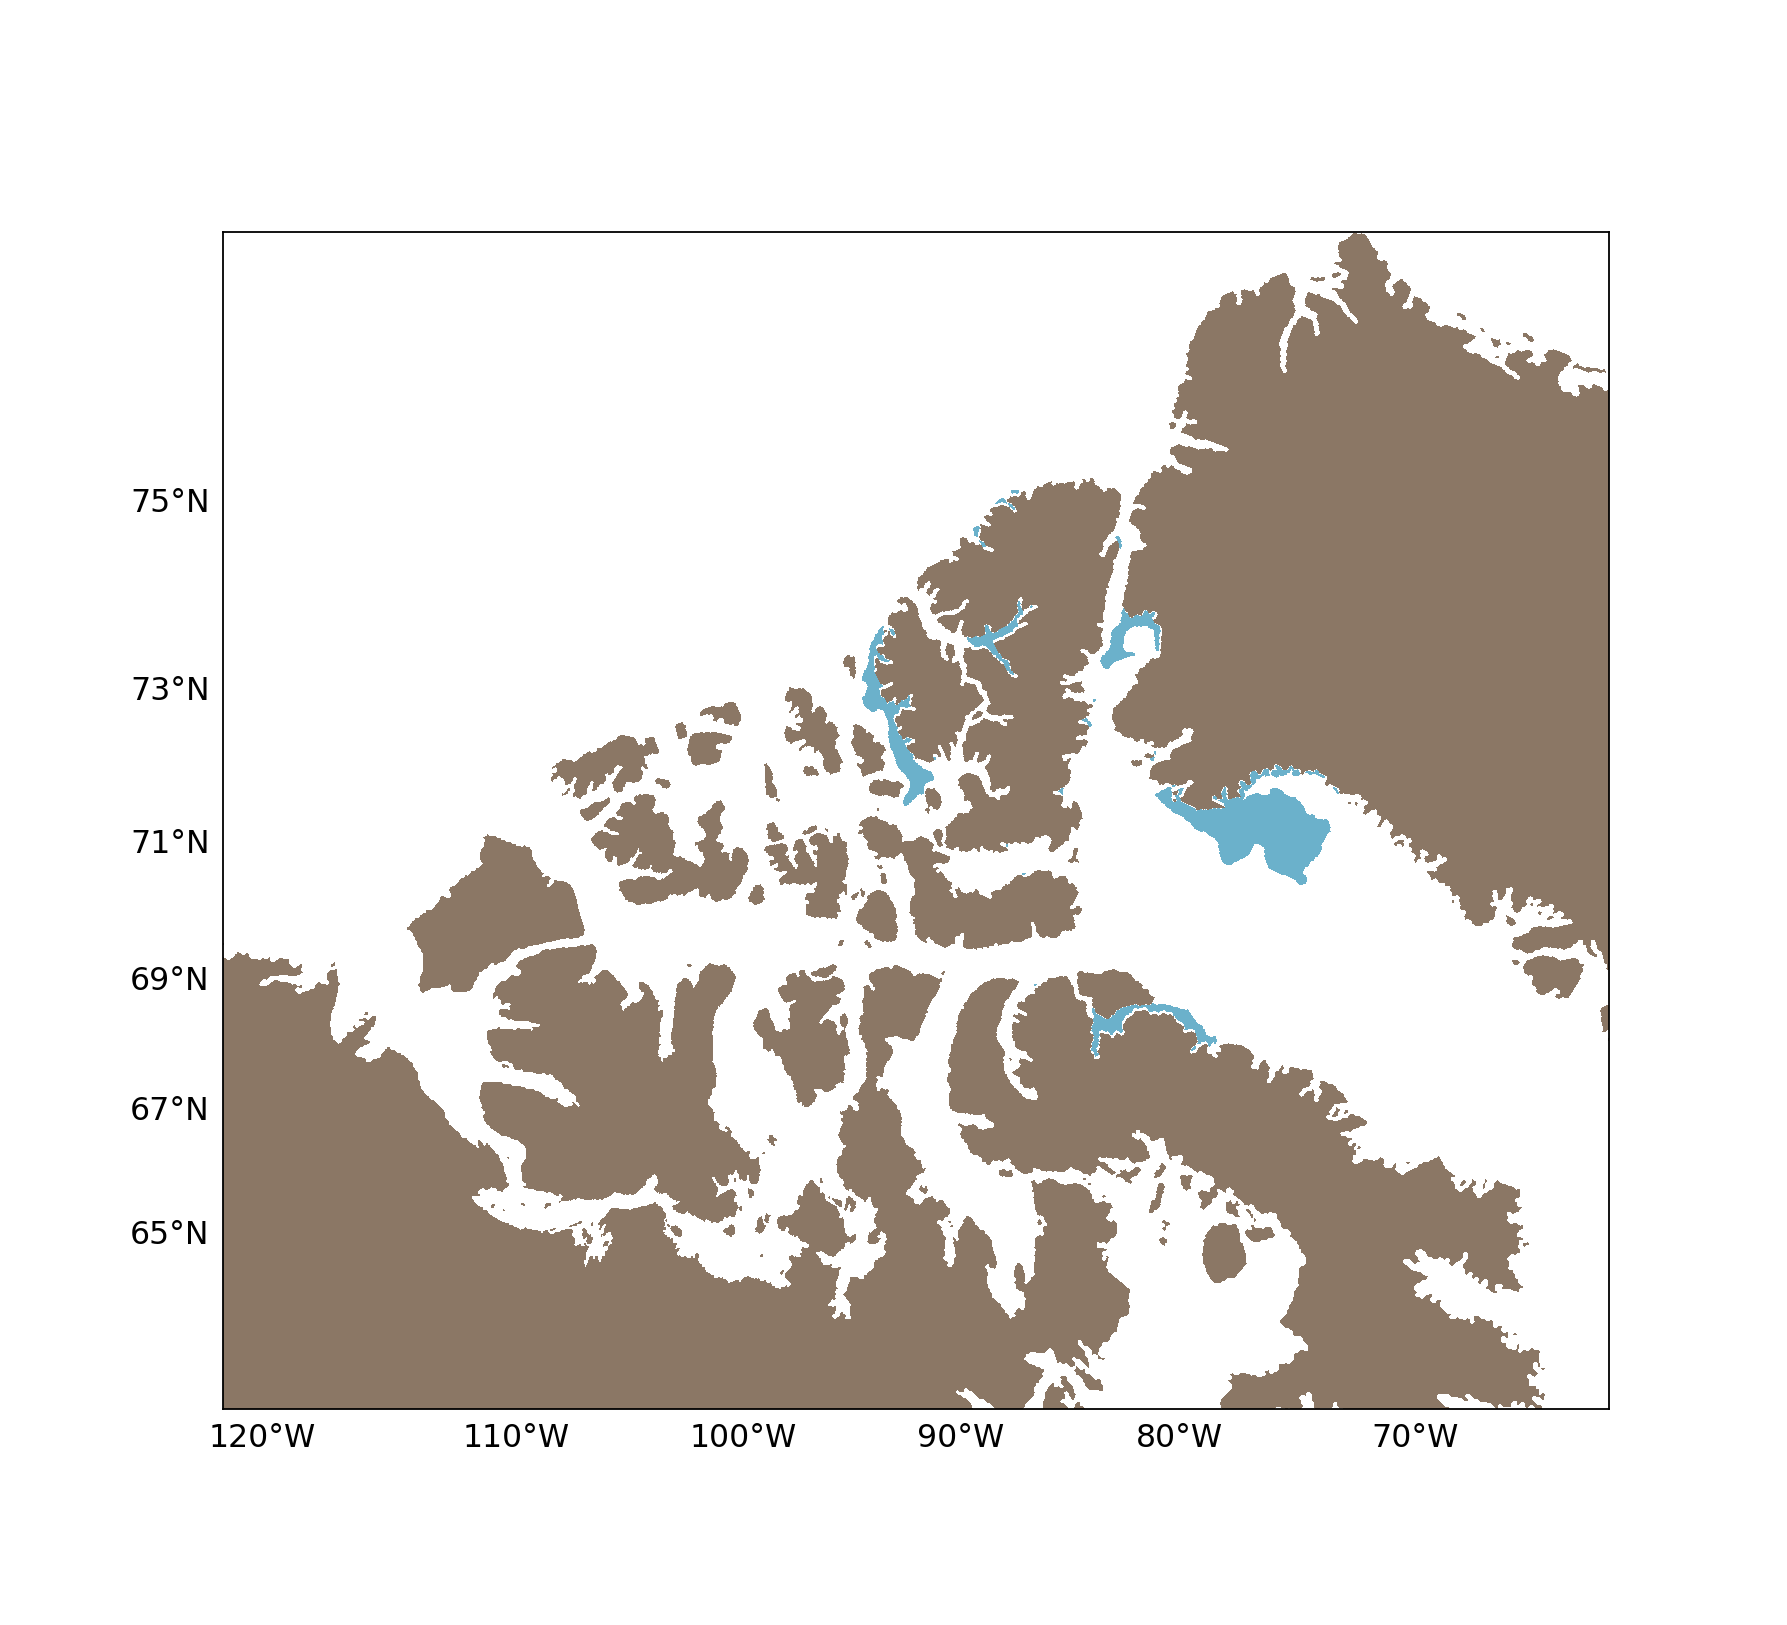

In [18]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y    = proj(lons, lats)
colour  = cmocean.cm.ice_r

proj.contourf(x, y, RCD_glac[8,0,:,:], [0.3, 1], vmin=0.5, vmax=1, cmap=colour)

In [19]:
def months_overview(var, levels, min_v=0.5, max_v=1, proj=proj):
    ax   = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplotsax.pickle','rb'))
    
    x, y = proj(lons, lats)
    colour=cmocean.cm.ice_r
    depth = 0
    cbar  = proj.contourf(x, y, var[0, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,0])
    proj.contourf(x, y, var[1, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,1])
    proj.contourf(x, y, var[2, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,2])
    proj.contourf(x, y, var[3, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,3])
    proj.contourf(x, y, var[4, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,0])
    proj.contourf(x, y, var[5, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,1])
    proj.contourf(x, y, var[6, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,2])
    proj.contourf(x, y, var[7, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,3])
    proj.contourf(x, y, var[8, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,0])
    proj.contourf(x, y, var[9, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,1])
    proj.contourf(x, y, var[10, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,2])
#     proj.contourf(x, y, var[11, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,3])
    
    ax[0,0].set_title('January')
    ax[0,1].set_title('February')
    ax[0,2].set_title('March')
    ax[0,3].set_title('April')
    ax[1,0].set_title('May')
    ax[1,1].set_title('June')
    ax[1,2].set_title('July')
    ax[1,3].set_title('August')
    ax[2,0].set_title('September')
    ax[2,1].set_title('October')
    ax[2,2].set_title('November')
    ax[2,3].set_title('December')

    return

<IPython.core.display.Javascript object>


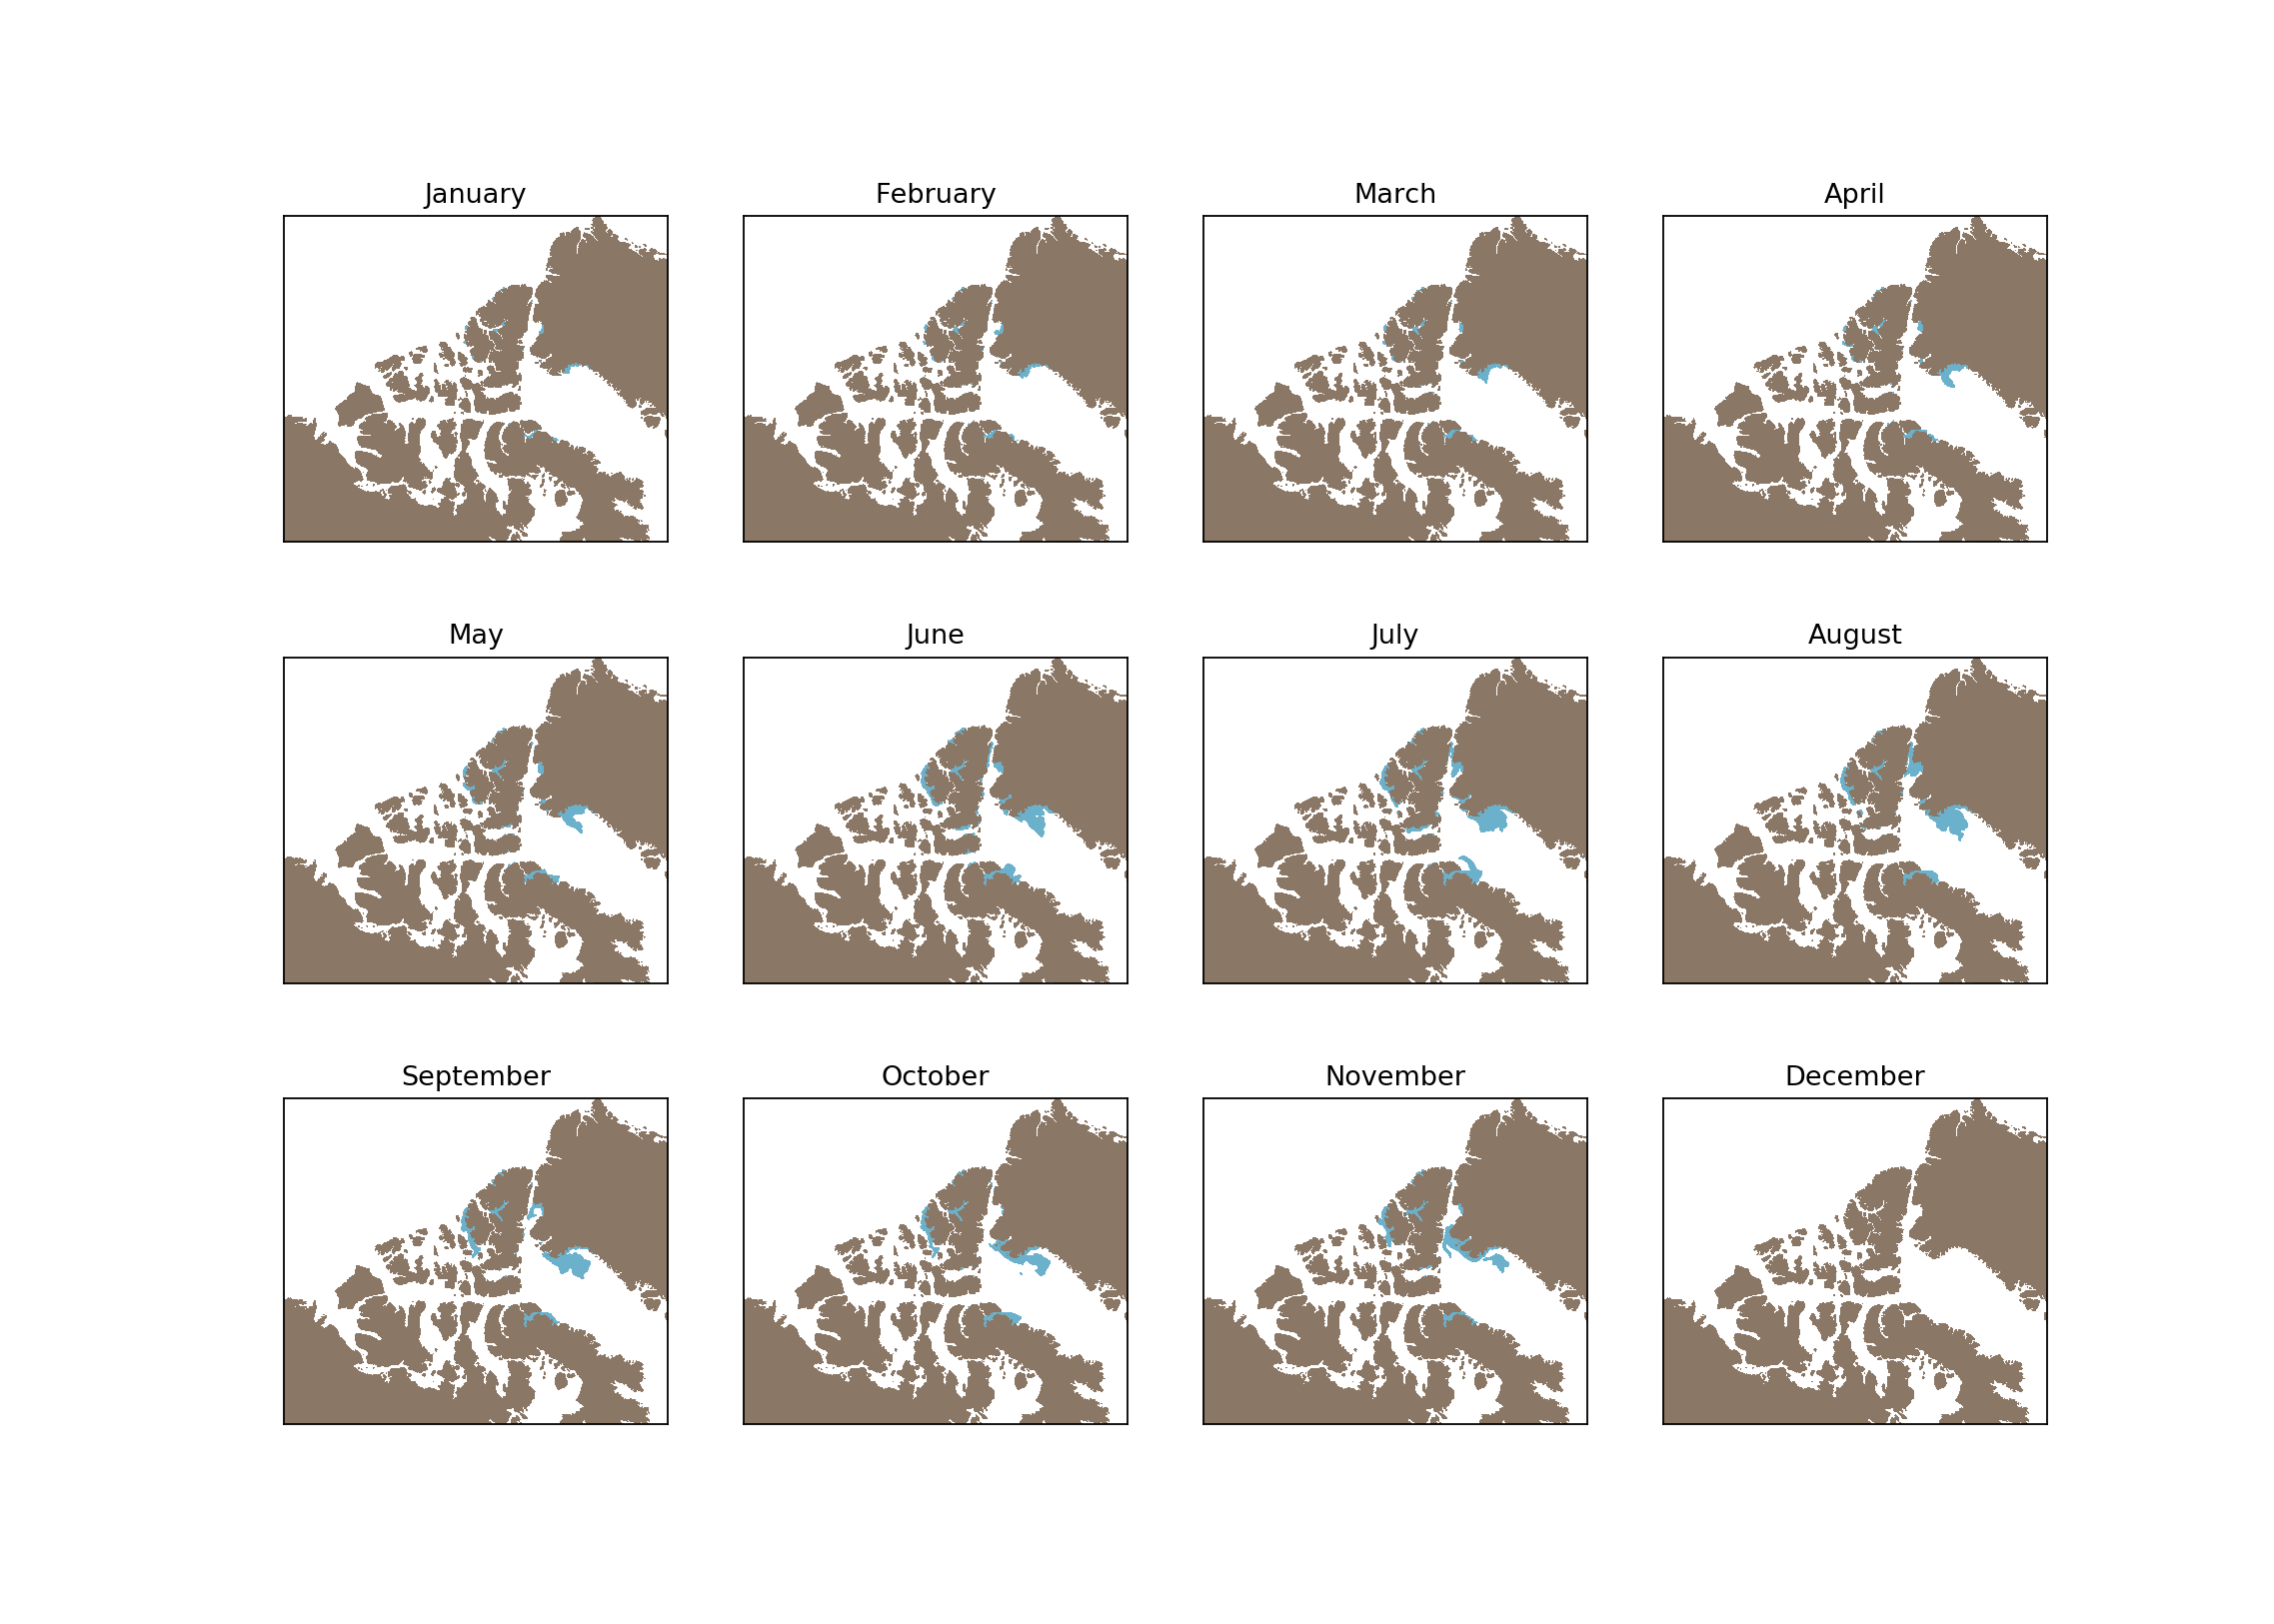

In [22]:
months_overview(RCD_glac, [0.3, 1])